In [1]:
import pandas as pd
import re
from tqdm.auto import tqdm
import yfinance as yf
# import swifter
import numpy as np
from collections import OrderedDict

#載入PCA套件
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import matplotlib.colors as colors
plt.rcParams['font.sans-serif'] = ['SimHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

import quantstats as qs


/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''加入產業'''
raw_sector = pd.read_excel('Data/TEJ_產業別.xlsx')

filter = (raw_sector['上市別'] == 'OTC') | (raw_sector['上市別'] == 'TSE')
raw_sector = raw_sector[filter]
raw_sector['codes'] = raw_sector.apply(lambda x: x['代號'] + '.TW' if x['上市別'] == 'TSE' else x['代號'] + '.TWO', axis = 1)
raw_sector = raw_sector[['名稱','codes','TSE新產業_名稱']]

sectors = list(set(raw_sector['TSE新產業_名稱']))

raw_sector = raw_sector.reset_index(drop = True)

In [3]:
# command = ''
# for i in range(0,len(raw_sector['codes'])):
#     command += raw_sector['codes'][i]+' '
    

# raw_data = yf.download(command)['Close']
# raw_data.to_csv('Data2/raw_data.csv')

raw_data = pd.read_csv('Data2/raw_data.csv', index_col = 0)
time_index = pd.to_datetime(raw_data.index)
stock_column = raw_data.columns

# 市值 ＆ PB

In [4]:
value = pd.read_excel('Data2/PB_Value.xlsx')
filter = (value['市場別'] == 'OTC') | (value['市場別'] == 'TSE')
value  = value[filter]
value['codes'] = value.apply(lambda x: x['代號'] + '.TW' if x['市場別'] == 'TSE' else x['代號'] + '.TWO', axis = 1)
value['財報發布日'] = pd.to_datetime(value['財報發布日'])

In [5]:
tmp_index = list(time_index)
for tmp in tqdm(value['財報發布日']):
    if tmp not in tmp_index:
        tmp_index.append(tmp)
tmp_index.sort()

100%|██████████| 112260/112260 [00:15<00:00, 7077.33it/s] 


In [6]:
raw_df_value = pd.DataFrame(index = tmp_index)
for i in tqdm(range(0,len(stock_column))):
    tmp = value[value['codes'] == stock_column[i]][['財報發布日','季底普通股市值','每股淨值(C)','季底每股稅前淨利']]
    tmp.index = tmp['財報發布日'].values
    tmp = tmp.sort_index()
    tmp = tmp.drop_duplicates(subset = '財報發布日',keep = 'last')

    tmp_ = pd.DataFrame()
    tmp_[stock_column[i]] = tmp['季底普通股市值']
    raw_df_value = raw_df_value.join(tmp_[stock_column[i]]).ffill()
    
raw_df_value['time'] = raw_df_value.index
raw_df_value['type'] = raw_df_value.apply(lambda x: 1 if x.time in time_index else 0, axis = 1)
raw_df_value = raw_df_value[raw_df_value['type'] == 1]

del raw_df_value['time']
del raw_df_value['type']
raw_df_value = raw_df_value['2008':]

100%|██████████| 1817/1817 [02:01<00:00, 15.02it/s]


In [7]:
raw_df_PB = pd.DataFrame(index = tmp_index)
for i in tqdm(range(0,len(stock_column))):
    tmp = value[value['codes'] == stock_column[i]][['財報發布日','季底普通股市值','每股淨值(C)','季底每股稅前淨利']]
    tmp.index = tmp['財報發布日'].values
    tmp = tmp.sort_index()
    tmp = tmp.drop_duplicates(subset = '財報發布日',keep = 'last')

    tmp_ = pd.DataFrame()
    tmp_[stock_column[i]] = tmp['每股淨值(C)']
    raw_df_PB = raw_df_PB.join(tmp_[stock_column[i]]).ffill()
    
raw_df_PB['time'] = raw_df_PB.index
raw_df_PB['type'] = raw_df_PB.apply(lambda x: 1 if x.time in time_index else 0, axis = 1)
raw_df_PB = raw_df_PB[raw_df_PB['type'] == 1]

del raw_df_PB['time']
del raw_df_PB['type']
raw_df_PB = raw_df_PB['2008':]

100%|██████████| 1817/1817 [02:00<00:00, 15.07it/s]


# PCA

In [8]:

VALUE_RANK = 0
VALUE_RANK_N = 3
T = 125 # 半衰期
N = 2 # PCA 成分
DAYS = 252*3 # PCA & PB
RANK_RESULT = 2 #　最後排名


In [9]:
raw_return = raw_data.pct_change()['2008':]
weighted_df = np.multiply(raw_return,raw_df_value)
weighted_df = weighted_df['2008':]

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


In [10]:
for sector in sectors:
    raw_sector[raw_sector['TSE新產業_名稱'] == sector]

In [11]:
sectors_df = pd.DataFrame()
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    tmp_ = weighted_df[tmp].mean(axis = 1)
    sectors_df[sectors[i]] = tmp_

In [12]:
# '''一開始再篩的時候，就篩市值'''
# sectors_df = pd.DataFrame()
# for i in range(0,len(sectors)):
#     tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
#     tmp_ = np.multiply(weighted_df[tmp], raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK)).mean(axis = 1)
#     sectors_df[sectors[i]] = tmp_

In [13]:
half_life = list((1/2)**(np.arange(T,0,-1)/T))
rolling_sectors_df = pd.DataFrame(sectors_df.rolling(T))

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [14]:
#輸入有多少成分我們想要留住分解
pca = PCA(n_components = N)

dates = []
centralities = {}
for i in tqdm(range(T, len(rolling_sectors_df))):
# for i in range(T, T+5):
    df = rolling_sectors_df.iloc[i,0].mul(half_life, axis = 0)
    date = df.index[-1]
    
    #將資料分成兩個主成份
    X = df.cov()
    pca.fit(X)
    x_pca = pca.transform(X)

    # 主成份的解釋力
    absorption_ratios = pca.explained_variance_ratio_

    # 各產業集中度
    # centralities = {'產業集中度':[]}
    centralities[date] = []
    for i in range(len(x_pca)):
        eigien_ratio = 0
        for j in range(0,N):
            eigien_ratio += (np.abs(x_pca[i,j])/ np.abs(x_pca.T[j]).sum())*absorption_ratios[j]
        centrality = eigien_ratio/absorption_ratios.sum()
        centralities[date].append(centrality)
        
centralities = pd.DataFrame(centralities)
centralities.index = df.keys()
centralities = centralities.T

100%|██████████| 3868/3868 [00:07<00:00, 496.52it/s]


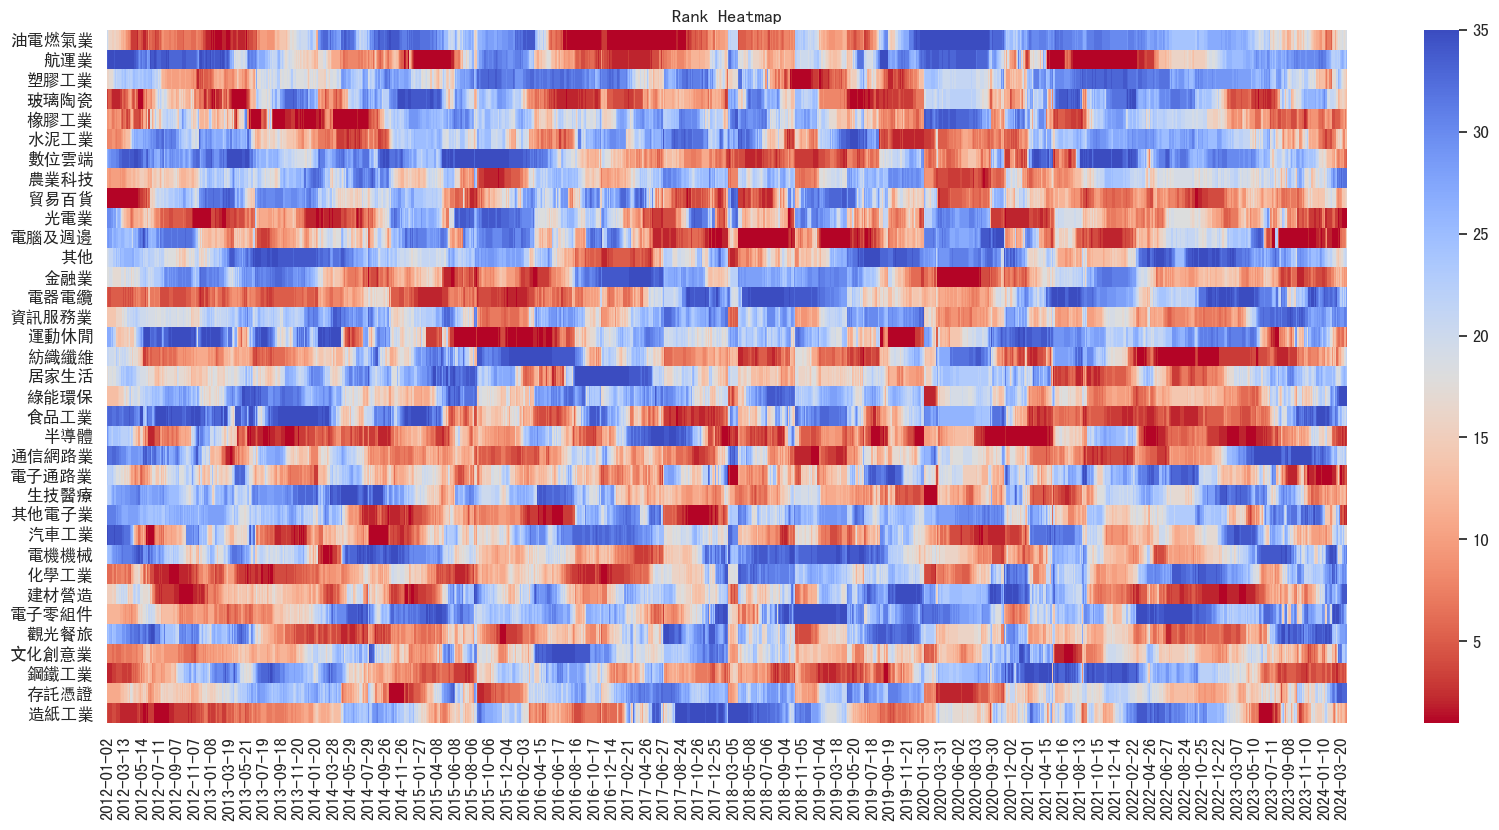

In [15]:
standard_centralities = (centralities - centralities.rolling(DAYS).mean())/centralities.rolling(DAYS).std()

cmap = colors.LinearSegmentedColormap.from_list("brw", ["white", "blue", "red"], N = len(sectors))

# rank_centralities = centralities.rank(axis = 1, ascending = False).T
rank_centralities = standard_centralities['2012':].rank(axis = 1, ascending = False)
plt.figure(figsize = (20,9))
# sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
sns.set_style("whitegrid",{"font.sans-serif":['SimHei']})
sns.heatmap(rank_centralities.T, annot = False, cmap='coolwarm_r')
plt.title('Rank Heatmap')
plt.savefig('Rank Heatmap.png')
plt.show()

# PB ratio

In [16]:
PB_ratio = np.multiply(raw_data['2008':],1/raw_df_PB)

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  """Entry point for launching an IPython kernel.


In [17]:
PB_sector = pd.DataFrame()
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    tmp_ = PB_ratio[tmp].sum(axis = 1)
    PB_sector[sectors[i]] = tmp_

In [18]:
tmp = PB_sector/PB_sector.rolling(DAYS).mean()
PB_star = pd.DataFrame()
for sector in list(PB_sector.columns):
    columns = list(PB_sector.columns)
    columns.remove(sector)
    PB_star[sector] = tmp[sector]/(tmp[columns]).mean(axis = 1)

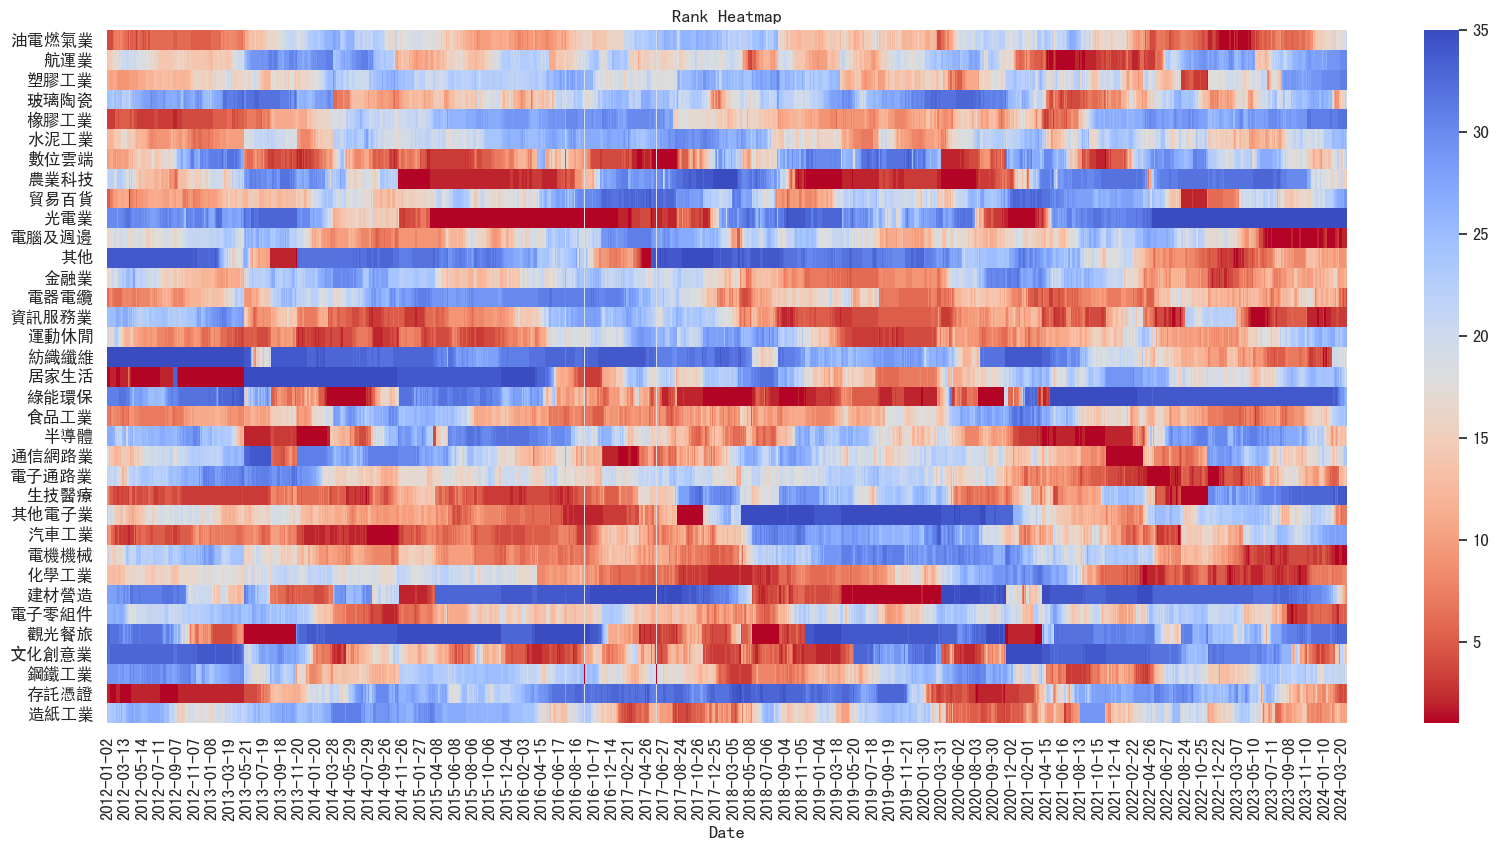

In [19]:
rank_PB_star = PB_star['2012':].rank(axis = 1, ascending = False)
plt.figure(figsize = (20,9))
# sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
sns.set_style("whitegrid",{"font.sans-serif":['SimHei']})
sns.heatmap(rank_PB_star.T, annot = False, cmap='coolwarm_r')
plt.title('Rank Heatmap')
plt.savefig('Rank Heatmap.png')
plt.show()

# 交易

In [20]:
# sectors_df = pd.DataFrame()
# for i in range(0,len(sectors)):
#     tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
#     tmp_ = raw_return[tmp].mean(axis = 1)
#     sectors_df[sectors[i]] = tmp_

In [21]:
sectors_df = pd.DataFrame()
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    if VALUE_RANK == 0 :
        tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK_N)).mean(axis = 1)
    else:
        tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK)).mean(axis = 1)
    sectors_df[sectors[i]] = tmp_

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  """


In [22]:
def get_results(result_type, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], rank = RANK_RESULT):
    
    if result_type == 1:
        rank_PB_star_bool = rank_PB_star > RANK_RESULT
        rank_centralities_bool = rank_centralities > RANK_RESULT

    elif result_type == 2:
        rank_PB_star_bool = rank_PB_star <= RANK_RESULT
        rank_centralities_bool = rank_centralities > RANK_RESULT

    elif result_type == 4:
        rank_PB_star_bool = rank_PB_star <= RANK_RESULT
        rank_centralities_bool = rank_centralities <= RANK_RESULT

    elif result_type == 3:
        rank_PB_star_bool = rank_PB_star > RANK_RESULT
        rank_centralities_bool = rank_centralities <= RANK_RESULT

    bool_df = (rank_PB_star_bool*rank_centralities_bool).shift(1)


    DB_new = DB_new*bool_df
    # yearly_return = (DB_new*bool_df).mean()*252
    yearly_return = ((DB_new*bool_df).sum(axis = 1)/bool_df.sum(axis = 1))*252

    return bool_df, DB_new, yearly_return

In [23]:
df_results = pd.DataFrame()

bool_no_b_1, no_b_1, df_results['no bubble_1'] = get_results(result_type = 1)
bool_no_b_2, no_b_2, df_results['no bubble_2'] = get_results(result_type = 2)
bool_b_r, b_r, df_results['bubble runup'] = get_results(result_type = 3)
bool_b_s, b_s, df_results['bubble selloff'] = get_results(result_type = 4)

df_results

,no bubble_1,no bubble_2,bubble runup,bubble selloff
Date,,,,
2012-01-02,NaN,NaN,NaN,NaN
2012-01-03,0.898305,0.865582,1.327312,NaN
2012-01-04,0.527557,-0.439403,0.108531,NaN
2012-01-05,0.383392,-0.343977,0.784528,NaN
2012-01-06,0.667828,1.129485,-2.656067,NaN
...,...,...,...,...
2024-04-02,0.212845,-0.105858,1.793541,NaN
2024-04-03,-0.396453,0.420292,-0.154860,NaN
2024-04-08,2.103174,1.955262,-0.043276,NaN


In [24]:
pd.DataFrame(df_results.mean())

,0
no bubble_1,0.094880
no bubble_2,0.088088
bubble runup,0.138568
bubble selloff,0.264719


[*********************100%***********************]  1 of 1 completed


                           Strategy
-------------------------  ----------
Start Period               2012-01-03
End Period                 2024-04-11
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          193.45%
CAGR﹪                     9.16%

Sharpe                     0.68
Prob. Sharpe Ratio         99.03%
Smart Sharpe               0.68
Sortino                    0.96
Smart Sortino              0.95
Sortino/√2                 0.68
Smart Sortino/√2           0.67
Omega                      1.13

Max Drawdown               -31.63%
Longest DD Days            771
Volatility (ann.)          14.87%
Calmar                     0.29
Skew                       -0.4
Kurtosis                   4.54

Expected Daily %           0.04%
Expected Monthly %         0.73%
Expected Yearly %          8.63%
Kelly Criterion            6.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.5%
Expected Shortfall (cVaR)  -1.5%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-05,2022-10-25,2024-02-15,771,-31.631863,-30.227107
2,2020-01-15,2020-03-19,2020-07-09,176,-28.723517,-24.311871
3,2015-04-28,2015-08-24,2017-05-11,744,-25.696876,-22.362513
4,2018-01-24,2019-01-04,2019-10-22,636,-16.622965,-15.394147
5,2012-03-05,2012-06-04,2013-05-06,427,-15.341033,-14.051873


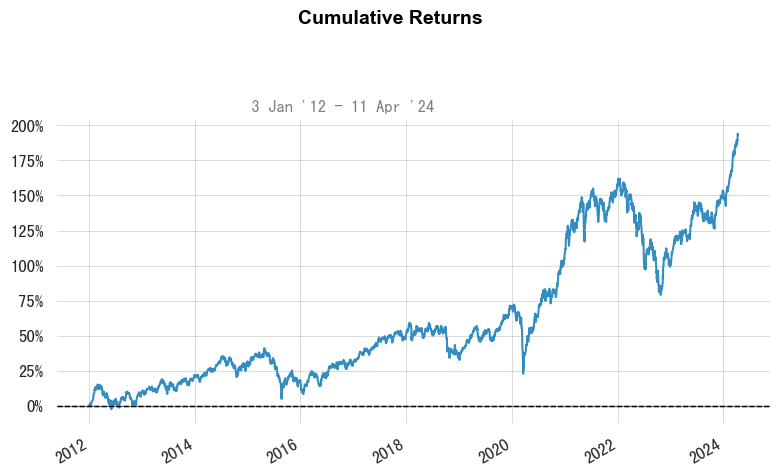

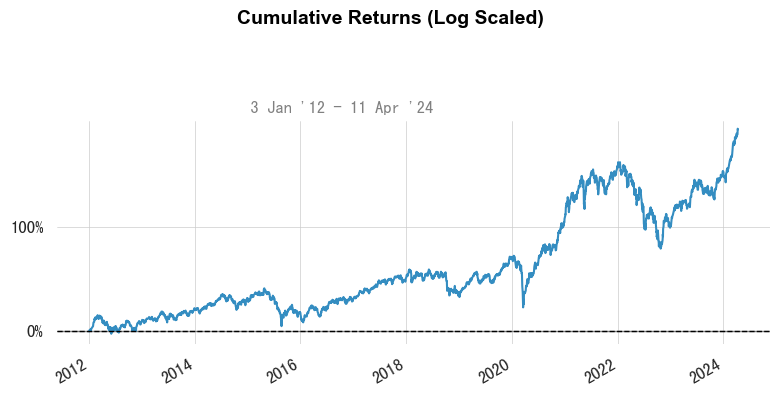

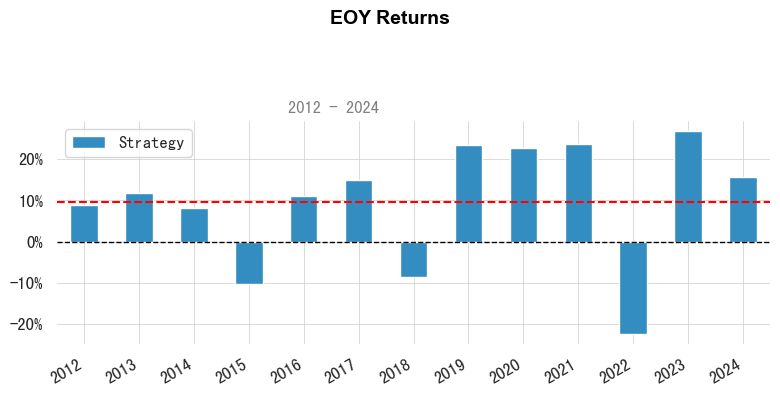

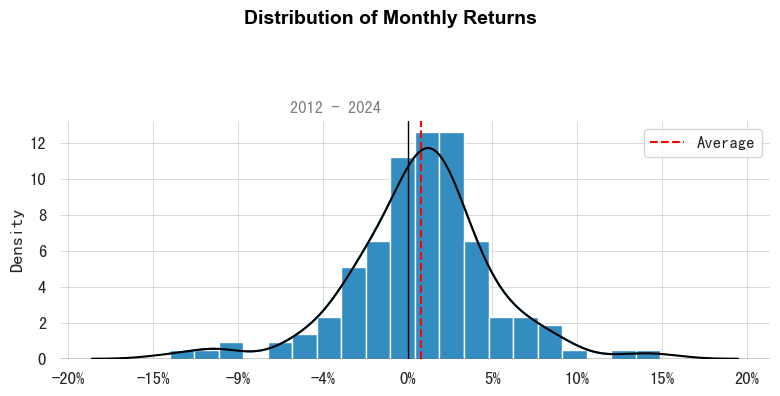

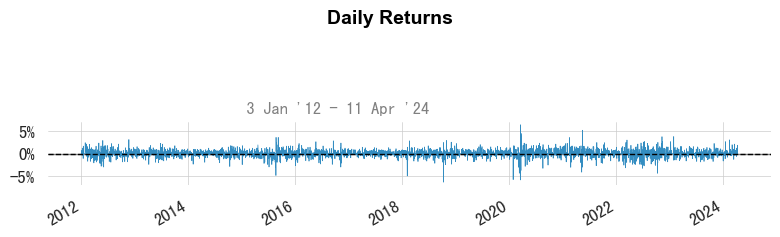

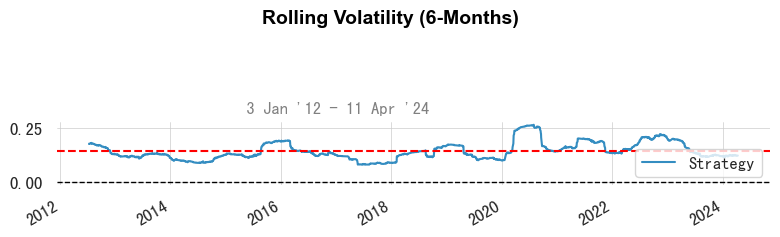

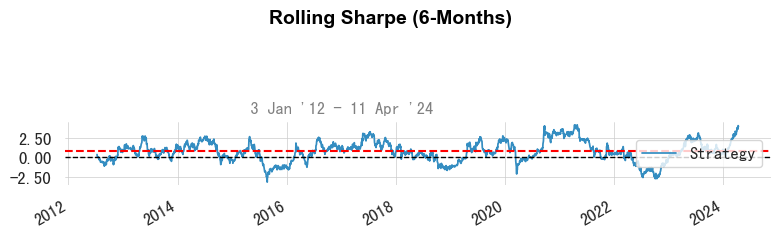

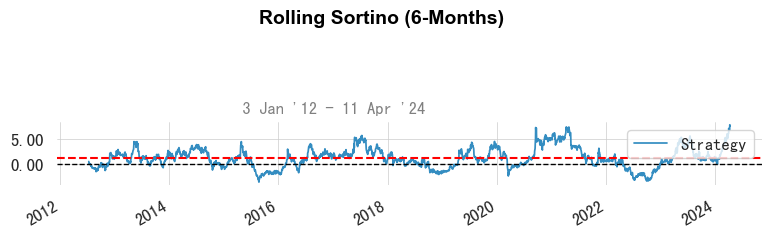

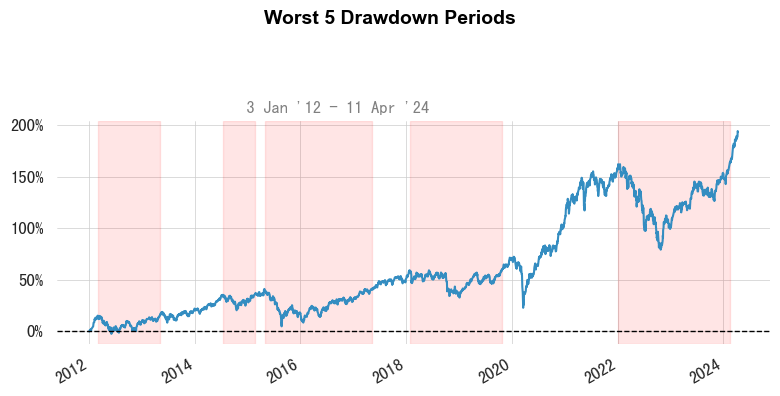

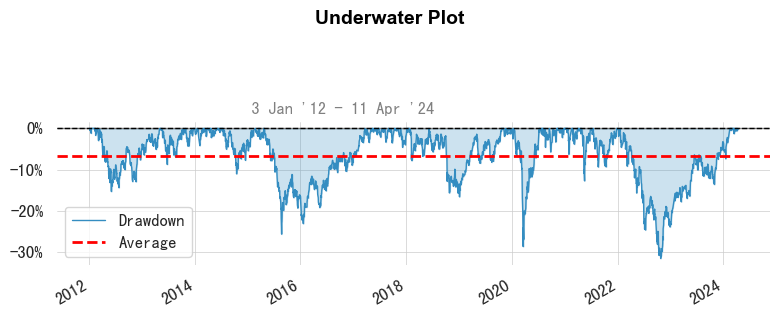

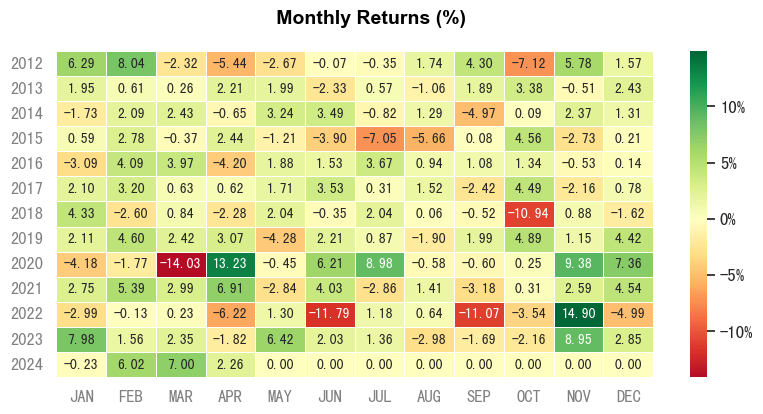

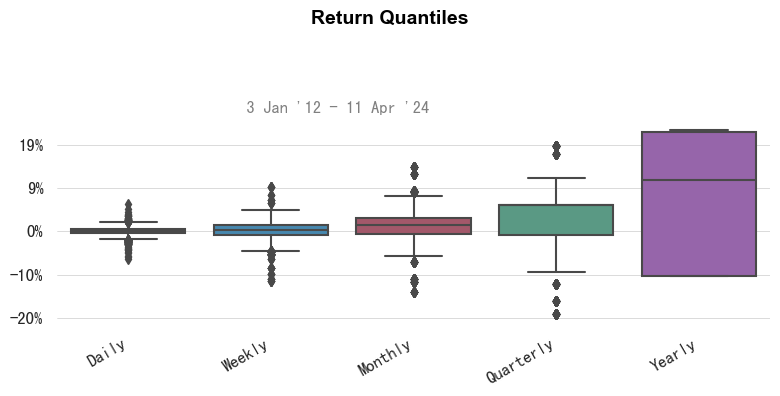

In [25]:
# 大盤
market = yf.download('^TWII')['Close']
market_return = market[market.index > pd.to_datetime('2011-01-01')].pct_change()
qs.reports.full(market_return['2012':])

                           Strategy
-------------------------  ----------
Start Period               2012-01-02
End Period                 2024-04-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          362.47%
CAGR﹪                     13.28%

Sharpe                     1.03
Prob. Sharpe Ratio         99.97%
Smart Sharpe               0.95
Sortino                    1.42
Smart Sortino              1.3
Sortino/√2                 1.0
Smart Sortino/√2           0.92
Omega                      1.21

Max Drawdown               -29.36%
Longest DD Days            2090
Volatility (ann.)          13.37%
Calmar                     0.45
Skew                       -0.92
Kurtosis                   8.04

Expected Daily %           0.05%
Expected Monthly %         1.04%
Expected Yearly %          12.5%
Kelly Criterion            9.79%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.33%
Expected Shortfall (cVaR)  -1.33%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-04-10,2015-08-24,2019-12-30,2090,-29.361093,-26.906612
2,2020-01-03,2020-03-19,2020-06-19,168,-25.621480,-22.318948
3,2012-03-05,2012-06-04,2013-03-26,386,-20.396762,-18.148710
4,2022-02-22,2022-10-13,2023-03-23,394,-16.935542,-16.074843
5,2021-07-06,2021-10-22,2021-12-06,153,-12.047594,-11.368264


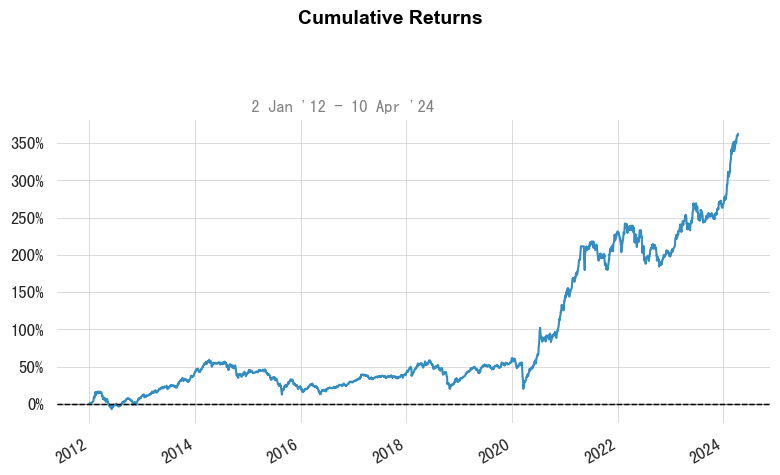

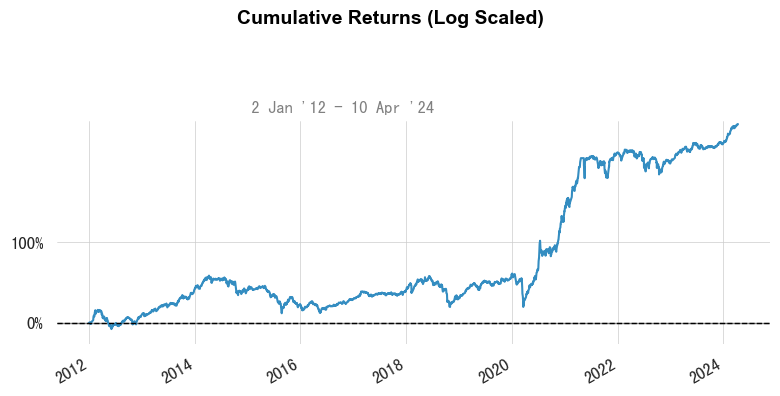

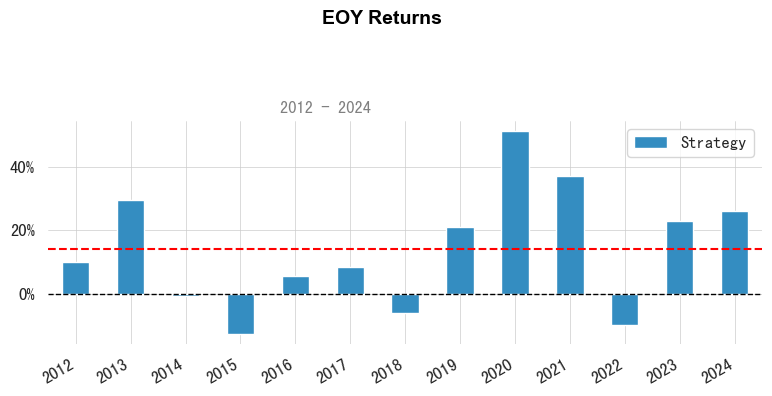

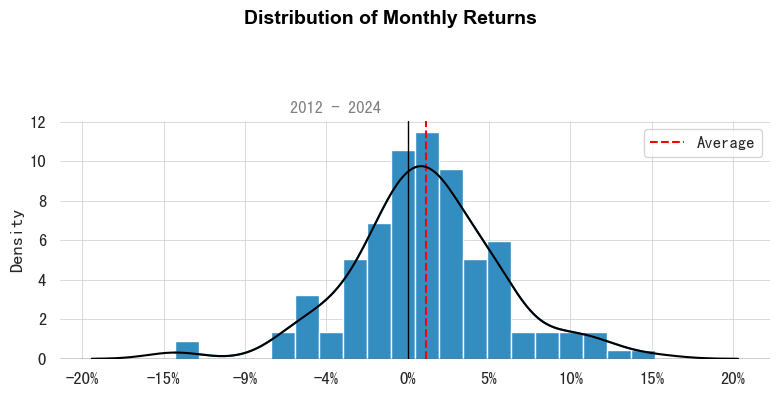

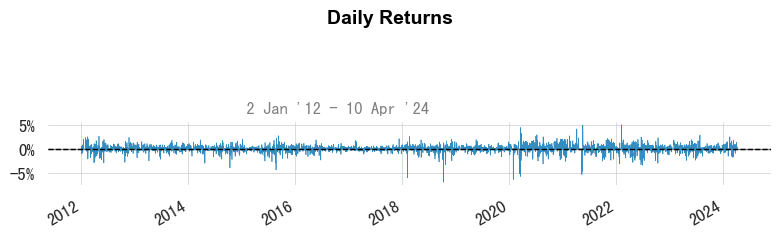

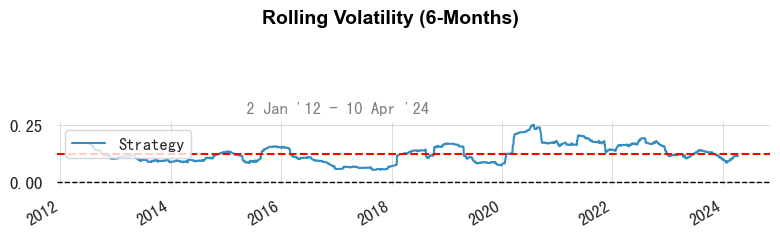

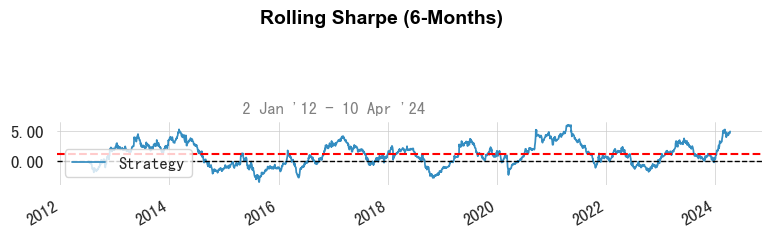

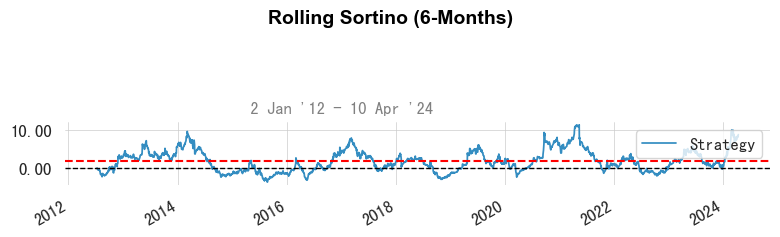

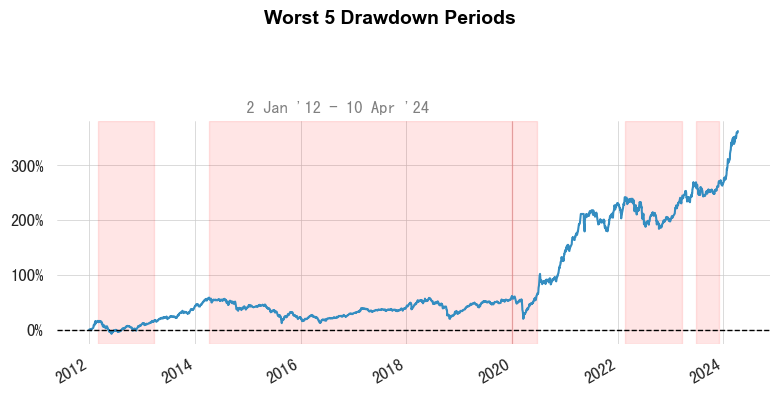

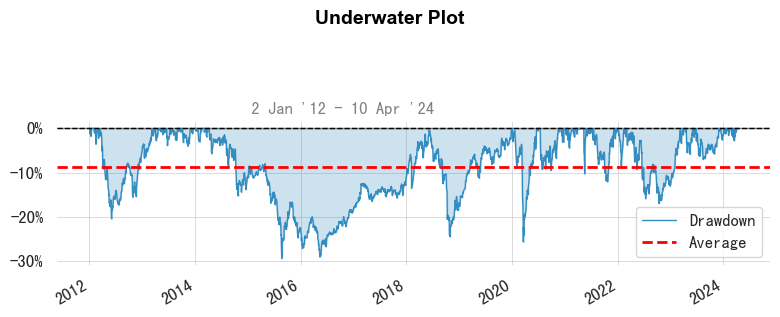

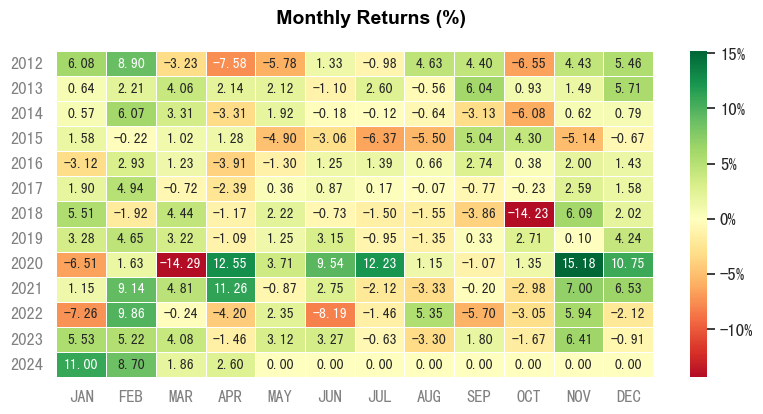

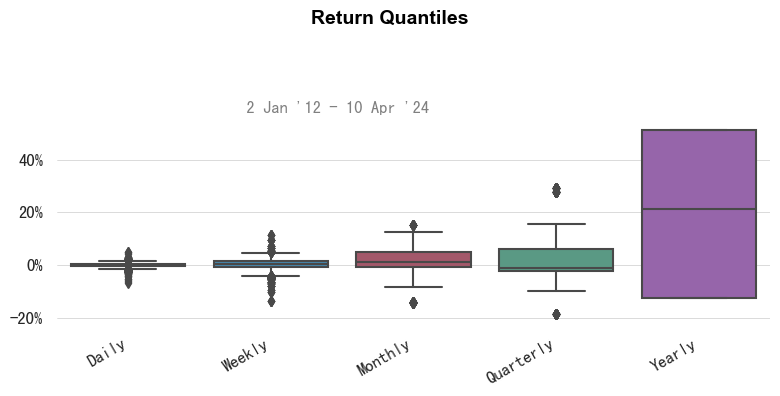

In [26]:
df = b_r.sum(axis = 1)/bool_b_r.sum(axis = 1)
df.index = pd.to_datetime(df.index)
qs.reports.full(df)

# Black-Litterman

In [27]:
from pypfopt.black_litterman import BlackLittermanModel

In [28]:
sectors_df_mcap = pd.DataFrame()
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    tmp_ = raw_df_value[tmp].sum(axis = 1)
    sectors_df_mcap[sectors[i]] = tmp_

In [29]:
sectors_df_return = pd.DataFrame()
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    tmp_ = raw_return[tmp].mean(axis = 1)
    sectors_df_return[sectors[i]] = tmp_

In [30]:
from pypfopt import black_litterman, risk_models

"""
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
market_prices is a series of S&P500 prices
"""

mcaps = sectors_df_mcap.iloc[-1].to_dict()
cov_matrix = sectors_df_return.cov()
market_prices = market['2008':]
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

In [31]:
'''各個情況的相對漲跌'''


df_results = pd.DataFrame()

bool_no_b_1, no_b_1, df_results['no bubble_1'] = get_results(result_type = 1)
bool_no_b_2, no_b_2, df_results['no bubble_2'] = get_results(result_type = 2)
bool_b_r, b_r, df_results['bubble runup'] = get_results(result_type = 3)
bool_b_s, b_s, df_results['bubble selloff'] = get_results(result_type = 4)

df_results

,no bubble_1,no bubble_2,bubble runup,bubble selloff
Date,,,,
2012-01-02,NaN,NaN,NaN,NaN
2012-01-03,0.898305,0.865582,1.327312,NaN
2012-01-04,0.527557,-0.439403,0.108531,NaN
2012-01-05,0.383392,-0.343977,0.784528,NaN
2012-01-06,0.667828,1.129485,-2.656067,NaN
...,...,...,...,...
2024-04-02,0.212845,-0.105858,1.793541,NaN
2024-04-03,-0.396453,0.420292,-0.154860,NaN
2024-04-08,2.103174,1.955262,-0.043276,NaN


# 各個類別 prior


In [35]:
type_df = bool_no_b_1.applymap(lambda x: 1 if x == True else 0)+bool_no_b_2.applymap(lambda x: 2 if x == True else 0)+bool_b_r.applymap(lambda x: 3 if x == True else 0)+bool_b_s.applymap(lambda x: 4 if x == True else 0)

In [41]:
type_df.iloc[1
             
             ].values

array([1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [ ]:
Q = np.array([-0.20, 0.05, 0.10, 0.15]).reshape(-1, 1)
P = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0],
    ]
)



In [ ]:
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

# viewdict = {"AAPL": 0.20, "BBY": -0.30, "BAC": 0, "SBUX": -0.2, "T": 0.15}
bl = BlackLittermanModel(cov_matrix, Q = Q, P = P)

rets = bl.bl_returns()
ef = EfficientFrontier(rets, cov_matrix)

# OR use return-implied weights
delta = black_litterman.market_implied_risk_aversion(market_prices)
bl.bl_weights(delta)
weights = bl.clean_weights()

/home/akilin/anaconda3/envs/gamma/lib/python3.7/site-packages/pypfopt/black_litterman.py:257: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


AssertionError: P must have dimensions KxN

In [ ]:
ans = 0
for i in range(0,len(weights)):
    ans += weights[list(weights.keys())[i]]